<a href="https://colab.research.google.com/github/victorbahlangene/fastai-fastbook22/blob/main/06_why_you_should_use_a_framework_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular model

# Setup

In [1]:
# to use kaggle api #
!pip install kaggle

# kaggle API creds #
creds = '{"username":"victorbahlangene","key":"2cd1abe2f1c35ea3060e6a2f18a055ea"}'

from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 25.6MB/s]

In [3]:
path

PosixPath('titanic')

In [4]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

# Data Analysis

In [5]:
path/"train.csv"

Path('titanic/train.csv')

In [8]:
Path("titanic").ls()

(#3) [Path('titanic/test.csv'),Path('titanic/gender_submission.csv'),Path('titanic/train.csv')]

In [9]:
df = pd.read_csv(path/"train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


**Add more cols**

In [10]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==1
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master")).value_counts(dropna=False)

add_features(df)

In [11]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,2.11,NaN,1,True,1,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C,4.28,ABC,1,True,1,NaN
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,2.19,NaN,0,False,1,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,3.99,ABC,1,True,2,NaN
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,2.20,NaN,0,False,1,NaN


In [14]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,LogFare,Family,TicketFreq,Title
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00,891.00,891.00,891.00,0.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20,2.96,0.90,1.79,NaN
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69,0.97,1.61,1.36,NaN
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00,0.00,0.00,1.00,NaN
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91,2.19,0.00,1.00,NaN
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45,2.74,0.00,1.00,NaN
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00,3.47,1.00,2.00,NaN
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33,6.24,10.00,7.00,NaN


In [16]:
df.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'LogFare', 'Family', 'TicketFreq', 'Title'],
      dtype='object')

In [15]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked,Deck
count,891,891,891,204,889,203
unique,891,2,681,147,3,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S,ABC
freq,1,577,7,4,644,121


In [17]:
df.describe(include=[object]).columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Deck'], dtype='object')

In [18]:
procs = [Categorify, FillMissing, Normalize]

cat_names = ['Sex', 'Embarked', 'Deck','Pclass','Title']

cont_names = ['Age', 'SibSp', 'Parch', 'LogFare', "Alone", 'Family', 'TicketFreq']

In [19]:
RandomSplitter??

In [20]:
splits = RandomSplitter(seed=42)(df)

In [21]:
splits

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

In [23]:
to = TabularPandas (df, 
                    procs=procs, 
                    cat_names=cat_names, 
                    cont_names=cont_names,
                    y_names="Survived", y_block=CategoryBlock(), 
                    splits=splits)

In [24]:
to.show()

,Sex,Embarked,Deck,Pclass,Title,Age_na,Age,SibSp,Parch,LogFare,Alone,Family,TicketFreq,Survived
788,male,S,#na#,3,#na#,False,1.00,1.00,2.00,3.07,0.00,3.00,2.00,1
525,male,Q,#na#,3,#na#,False,40.50,0.00,0.00,2.17,0.00,0.00,1.00,0
821,male,S,#na#,3,#na#,False,27.00,0.00,0.00,2.27,0.00,0.00,1.00,1
253,male,S,#na#,3,#na#,False,30.00,1.00,0.00,2.84,1.00,1.00,2.00,0
374,female,S,#na#,3,#na#,False,3.00,3.00,1.00,3.09,0.00,4.00,4.00,0
98,female,S,#na#,2,#na#,False,34.00,0.00,1.00,3.18,1.00,1.00,2.00,1
215,female,C,DE,1,#na#,False,31.00,1.00,0.00,4.74,1.00,1.00,3.00,1
313,male,S,#na#,3,#na#,False,28.00,0.00,0.00,2.19,0.00,0.00,1.00,0
281,male,S,#na#,3,#na#,False,28.00,0.00,0.00,2.18,0.00,0.00,1.00,0
305,male,S,ABC,1,#na#,False,0.92,1.00,2.00,5.03,0.00,3.00,4.00,1


In [25]:
to.classes

{'Sex': ['#na#', 'female', 'male'],
 'Embarked': ['#na#', 'C', 'Q', 'S'],
 'Deck': ['#na#', 'ABC', 'DE', 'FG'],
 'Pclass': ['#na#', 1, 2, 3],
 'Title': ['#na#'],
 'Age_na': ['#na#', False, True]}

In [26]:
dls = to.dataloaders(path=".")

In [27]:
dls.show_batch()

,Sex,Embarked,Deck,Pclass,Title,Age_na,Age,SibSp,Parch,LogFare,Alone,Family,TicketFreq,Survived
0,female,Q,#na#,3,#na#,False,15.00,0.00,-0.00,2.20,0.00,-0.00,1.00,1
1,male,S,#na#,3,#na#,False,44.00,0.00,-0.00,2.20,0.00,-0.00,1.00,0
2,male,S,ABC,1,#na#,False,61.00,0.00,-0.00,3.54,0.00,-0.00,1.00,0
3,male,S,#na#,3,#na#,True,28.00,8.00,2.00,4.26,0.00,10.00,7.00,0
4,male,S,#na#,3,#na#,False,27.00,0.00,-0.00,2.19,0.00,-0.00,1.00,0
5,male,S,DE,1,#na#,False,51.00,0.00,-0.00,3.32,0.00,-0.00,1.00,1
6,female,S,#na#,2,#na#,False,34.00,0.00,-0.00,2.64,0.00,-0.00,1.00,1
7,male,S,#na#,3,#na#,False,20.00,0.00,-0.00,2.38,0.00,-0.00,2.00,0
8,male,S,ABC,1,#na#,False,70.00,1.00,1.00,4.28,0.00,2.00,2.00,0
9,female,Q,#na#,3,#na#,False,32.00,1.00,1.00,2.80,0.00,2.00,2.00,0


# model train

In [28]:
tabular_learner??

In [29]:
learn = tabular_learner(dls, layers=[10,10], metrics=accuracy)

learning rate

SuggestedLRs(slide=0.0691830962896347, valley=0.0063095735386013985)

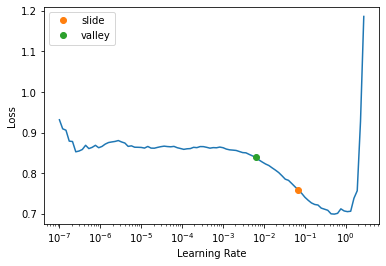

In [30]:
learn.lr_find(suggest_funcs=(slide,valley))

In [31]:
10**-1

0.1

In [32]:
learn.fit(16, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.612694,0.482878,0.780899,00:00
1,0.523841,0.427183,0.814607,00:00
2,0.485687,0.453134,0.808989,00:00
3,0.490160,0.493889,0.820225,00:00
4,0.482744,0.439400,0.814607,00:00
5,0.470100,0.413877,0.797753,00:00
6,0.462483,0.421209,0.797753,00:00
7,0.458091,0.398184,0.820225,00:00
8,0.448708,0.430946,0.820225,00:00
9,0.442673,0.408645,0.814607,00:00


# Ensembling

## create test dls

In [34]:
path.ls()

(#3) [Path('titanic/test.csv'),Path('titanic/gender_submission.csv'),Path('titanic/train.csv')]

In [35]:
test_df = pd.read_csv(path/"test.csv")
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.05,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00,0,0,PC 17758,108.90,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50,0,0,SOTON/O.Q. 3101262,7.25,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.05,NaN,S


In [36]:
??dls.test_dl

In [37]:
tst_dl = dls.test_dl(test_df)

KeyError: ignored

add missing cols in test_df

In [38]:
add_features(test_df)

In [39]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q,2.18,NaN,0,False,1,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S,2.08,NaN,1,True,1,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q,2.37,NaN,0,False,1,NaN
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S,2.27,NaN,0,False,1,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S,2.59,NaN,2,False,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.05,NaN,S,2.20,NaN,0,False,1,NaN
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00,0,0,PC 17758,108.90,C105,C,4.70,ABC,0,False,1,NaN
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50,0,0,SOTON/O.Q. 3101262,7.25,NaN,S,2.11,NaN,0,False,1,NaN
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.05,NaN,S,2.20,NaN,0,False,1,NaN


dls.test_dl formats the test dataframe to be similar to the train dls

In [42]:
dls.show_batch()

,Sex,Embarked,Deck,Pclass,Title,Age_na,Age,SibSp,Parch,LogFare,Alone,Family,TicketFreq,Survived
0,male,S,#na#,3,#na#,True,28.00,0.00,-0.00,2.17,0.00,-0.00,1.00,0
1,male,S,DE,1,#na#,False,42.00,1.00,-0.00,3.98,1.00,1.00,1.00,1
2,female,S,#na#,3,#na#,True,28.00,1.00,-0.00,2.84,1.00,1.00,2.00,1
3,male,S,#na#,2,#na#,False,21.00,0.00,-0.00,4.31,0.00,-0.00,5.00,0
4,male,S,#na#,3,#na#,False,16.00,0.00,-0.00,2.20,0.00,-0.00,1.00,1
5,female,C,DE,1,#na#,False,41.00,0.00,-0.00,4.91,0.00,-0.00,2.00,1
6,male,S,#na#,3,#na#,False,22.00,0.00,-0.00,2.17,0.00,-0.00,1.00,0
7,female,S,#na#,3,#na#,False,36.00,1.00,-0.00,2.91,1.00,1.00,1.00,1
8,male,S,#na#,3,#na#,False,21.00,0.00,-0.00,2.19,0.00,-0.00,1.00,0
9,male,S,DE,1,#na#,False,37.00,1.00,1.00,3.98,0.00,2.00,2.00,1


In [40]:
tst_dl = dls.test_dl(test_df)

AssertionError: ignored

In [43]:
test_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'LogFare', 'Deck', 'Family',
       'Alone', 'TicketFreq', 'Title'],
      dtype='object')

In [47]:
test_df["LogFare"].mode()

0   2.17
dtype: float64

In [46]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  LogFare      417 non-null    float64
 12  Deck         91 non-null     object 
 13  Family       418 non-null    int64  
 14  Alone        418 non-null    bool   
 15  TicketFreq   418 non-null    int64  
 16  Title        0 non-null      float64
dtypes: bool(1), float64(4), int64(6), object(6)
memory usage: 52.8+ KB


In [55]:
test_df["LogFare"] = test_df["LogFare"].fillna(test_df["LogFare"].mean())

In [56]:
test_df["LogFare"][test_df["LogFare"].isna()]

Series([], Name: LogFare, dtype: float64)

In [57]:
tst_dl = dls.test_dl(test_df)

In [58]:
tst_dl.show_batch()

,Sex,Embarked,Deck,Pclass,Title,Age_na,Age,SibSp,Parch,LogFare,Alone,Family,TicketFreq
0,male,Q,#na#,3,#na#,False,34.50,0.00,-0.00,2.18,0.00,-0.00,1.00
1,female,S,#na#,3,#na#,False,47.00,1.00,-0.00,2.08,1.00,1.00,1.00
2,male,Q,#na#,2,#na#,False,62.00,0.00,-0.00,2.37,0.00,-0.00,1.00
3,male,S,#na#,3,#na#,False,27.00,0.00,-0.00,2.27,0.00,-0.00,1.00
4,female,S,#na#,3,#na#,False,22.00,1.00,1.00,2.59,0.00,2.00,1.00
5,male,S,#na#,3,#na#,False,14.00,0.00,-0.00,2.32,0.00,-0.00,1.00
6,female,Q,#na#,3,#na#,False,30.00,0.00,-0.00,2.16,0.00,-0.00,1.00
7,male,S,#na#,2,#na#,False,26.00,1.00,1.00,3.40,0.00,2.00,1.00
8,female,C,#na#,3,#na#,False,18.00,0.00,-0.00,2.11,0.00,-0.00,1.00
9,male,S,#na#,3,#na#,False,21.00,2.00,-0.00,3.22,0.00,2.00,1.00


In [59]:
dls.show_batch()

,Sex,Embarked,Deck,Pclass,Title,Age_na,Age,SibSp,Parch,LogFare,Alone,Family,TicketFreq,Survived
0,female,C,#na#,3,#na#,False,0.75,2.00,1.00,3.01,0.00,3.00,4.00,1
1,male,C,#na#,3,#na#,False,20.00,0.00,-0.00,2.11,0.00,-0.00,1.00,1
2,male,S,#na#,3,#na#,False,26.00,0.00,-0.00,2.19,0.00,-0.00,1.00,0
3,male,C,ABC,1,#na#,False,46.00,0.00,-0.00,4.38,0.00,-0.00,2.00,0
4,male,S,ABC,1,#na#,True,28.00,0.00,-0.00,3.30,0.00,-0.00,1.00,0
5,male,S,ABC,1,#na#,False,45.00,1.00,-0.00,4.44,1.00,1.00,2.00,0
6,male,C,ABC,1,#na#,False,49.00,1.00,-0.00,4.50,1.00,1.00,2.00,1
7,male,C,#na#,3,#na#,False,0.42,0.00,1.00,2.25,1.00,1.00,1.00,1
8,female,C,ABC,1,#na#,False,18.00,1.00,-0.00,5.43,1.00,1.00,4.00,1
9,male,S,#na#,3,#na#,False,39.00,1.00,5.00,3.47,0.00,6.00,7.00,0


## ensembling with tst_dl

In [60]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.069)
    return learn.get_preds(dl=tst_dl)[0]

In [61]:
learns = [ensemble() for _ in range(5)]

In [65]:
ens_preds = torch.stack(learns).mean(0)

In [66]:
ens_preds

tensor([[0.9181, 0.0819],
        [0.6405, 0.3595],
        [0.9538, 0.0462],
        [0.8999, 0.1001],
        [0.4776, 0.5224],
        [0.8001, 0.1999],
        [0.4644, 0.5356],
        [0.9156, 0.0844],
        [0.3359, 0.6641],
        [0.8806, 0.1194],
        [0.9164, 0.0836],
        [0.8609, 0.1391],
        [0.0268, 0.9732],
        [0.9405, 0.0595],
        [0.0204, 0.9796],
        [0.0558, 0.9442],
        [0.9264, 0.0736],
        [0.7268, 0.2732],
        [0.5876, 0.4124],
        [0.5877, 0.4123],
        [0.8371, 0.1629],
        [0.6189, 0.3811],
        [0.0694, 0.9306],
        [0.7303, 0.2697],
        [0.1207, 0.8793],
        [0.9435, 0.0565],
        [0.0263, 0.9737],
        [0.7557, 0.2443],
        [0.7827, 0.2173],
        [0.8154, 0.1846],
        [0.9097, 0.0903],
        [0.9024, 0.0976],
        [0.5994, 0.4006],
        [0.5401, 0.4599],
        [0.7186, 0.2814],
        [0.6778, 0.3222],
        [0.5383, 0.4617],
        [0.5033, 0.4967],
        [0.8

In [68]:
test_df['Survived'] = (ens_preds[:,1]>0.5).int()

In [69]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title,Survived
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q,2.18,NaN,0,False,1,NaN,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S,2.08,NaN,1,True,1,NaN,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q,2.37,NaN,0,False,1,NaN,0
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S,2.27,NaN,0,False,1,NaN,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S,2.59,NaN,2,False,1,NaN,1
